In [12]:
# Import libraries
import nltk
import pandas as pd
import numpy as np
import math
import string
import re
import sklearn

# Dataset

In [13]:
# Defines training, validation and testing datasets
TRAIN = "LIAR_dataset/train.tsv"
VALID = "LIAR_dataset/valid.tsv"
TEST = "LIAR_dataset/test.tsv"

# Define a function for importing datasets as Pandas DafaFrame
def import_ds(ds):
    return pd.read_csv(ds, delimiter="\t", encoding='utf-8', header=None)

# Import datasets using the function
(train, valid, test) = (
    import_ds(TRAIN),
    import_ds(VALID),
    import_ds(TEST)
)

# Show first rows of training dataset
valid.head ()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [14]:
# Defines a function which selects only 'true' or 'false' labeled rows
def clean_ds(ds):
    # Selects rows and columns
    ds = ds.loc[
        # Keeps only rows with 'true' or 'false' labels
        ds[1].isin(['true', 'false']), 
        # Maintains only first and second column
        1:2 
    ]
    # Sets columns names
    ds.columns = ['label', 'text']
    # returns cleaned DataFrame
    return ds

# Clean datasets
(train, valid, test) = (
    clean_ds(train),
    clean_ds(valid),
    clean_ds(test)
)

# Shows first rows of training DataFrame 
train.head()

,label,text
0,false,Says the Annies List political group supports ...
3,false,Health care reform legislation is likely to ma...
5,true,The Chicago Bears have had more starting quart...
12,false,When Mitt Romney was governor of Massachusetts...
16,true,McCain opposed a requirement that the governme...


## Dataset balancing
For training ML algorithms correctly, it is required to have balanced datasets, meaning that 'true' and 'false' labels must have a probability of being extracted of 50% approximately. This means having the same number of each different labels.

In [15]:
# Checks 'true'/'false' labels balancing of datasets
print(train['label'].value_counts())
print(valid['label'].value_counts())
print(test['label'].value_counts())

false    1995
true     1676
Name: label, dtype: int64
false    263
true     169
Name: label, dtype: int64
false    249
true     208
Name: label, dtype: int64


# Features
The dataset discussed in the previous paragraph, "Dataset", contains just the news sentences (the "text" field) and the labels which state if a news is fake or not (the "label" field). However, for training a ML algorithm we cannot use plain text, which indeed does not give us any kind of information as is, but we need to extract some features from it instead.

This paragraph covers the extraction of such features for ML algorithms training.

In [16]:
# Definition of data used in training and testing

# Define input data (news texts column of train DataFrame)
Xtrain = train.text
# Define labels
Ytrain = train.label

# Define test data
Xtest = test.text
Ytest = test.label

# Define validation data
Xvalid = valid.text
Yvalid = valid.label

# Initializes predicted labels
Ypredict = None

In [17]:
# Extract the first three rows 
# from dataset for demonstration purpose
x = Xtrain[0:3]
y = Ytrain[0:3]

# Definition of a wrapper function to show human-readable vectorizer output
def demo_vectorizer(v, x):
    return pd.DataFrame(
        v.fit_transform(x).toarray(),
        columns=v.get_feature_names()
    ).head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MioPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


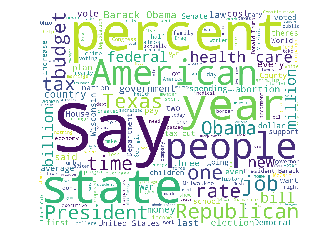

In [18]:
## liar dataset
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

words = nltk.word_tokenize(" ".join(Xtest.tolist()))

# clearly more cleaning is needed here, but really I should get a better tokenizer
stop = stopwords.words('english') 
cleanwords = [i for i in words if i not in stop and i.isalpha() and len(i) > 2]

wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(" ".join(cleanwords))


plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

## BOW (Bag Of Words)

In [32]:
# Importing sklearn countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer implements BOW for sklearn library
cv = CountVectorizer()
demo_vectorizer(cv, x)


,10,abortions,annies,bears,care,change,chicago,decades,demand,during,...,tenured,than,the,third,to,total,trimester,two,uw,years
0,0,1,1,0,0,0,0,0,1,0,...,0,0,1,1,0,0,1,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,1,0,0,1,1,0,1,...,1,1,4,0,0,1,0,1,1,1


In [33]:
# Filtering and cleaning words in BOW using nltk

# Imports stopwords
from nltk.corpus import stopwords
# Checks that stopwords have been correctly downloaded
nltk.download('stopwords')
# Initializes stopwords
sw = set(stopwords.words('english'))

# Inizialization of PorterStemmer (removes stems)
ps = nltk.PorterStemmer()

# Pre-processing using nltk
def nltk_preprocessor(sentence):
    # Lowerizes charachters
    pp = sentence.lower()
    # Use regular expression to replace email URL phone numbers, money, math symbols
    # Replace email addresses with 'email address'
    pp = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', pp)
    # Replace URLs with 'webaddress'
    pp = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress', pp)
    # Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
    pp = re.sub(r'£|\$', 'moneysymb', pp)
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    pp = re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr', pp)
    # Replace numbers with 'numbr'
    pp = re.sub(r'\d+(\.\d+)?', 'numbr', pp)
    # Remove punctation
    pp = re.sub(r'[^\w\d\s]', ' ', pp)
    # Replace whitespace between terms with a single space
    pp = re.sub(r'\s+', ' ', pp)
    # Remove leading and trailing whitespace
    pp = re.sub(r'^\s+|\s+?$', '', pp)
    # Here processed sentence is turned temporarily into a list
    # Stopwords, words in english that doesn't add information to the meaning of the sentences
    pp = ' '.join(w for w in pp.split() if w not in sw)
    # Remove word stems using a porter stemmer
    pp = ' '.join(ps.stem(w) for w in pp.split())
    # Returns preprocessed sentence
    return pp

# Using CountVectorizer with custom preprocessor
cv = CountVectorizer(preprocessor=nltk_preprocessor)
demo_vectorizer(cv, x)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MioPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,abort,anni,bear,care,chang,chicago,decad,demand,faculti,fire,...,start,support,surgeri,tenur,third,total,trimest,two,uw,year
0,1,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,1,1,0,1,1,...,1,0,0,1,0,1,0,1,1,1


### TF-IDF
SKlearn library provides a transformer for changing values in BOW. While default BOW provides the number of occurrences of a specific word in a specific sentence, TFIDF computes this number against the other values retrieving a frequency index from it.

**Note** Transformer from default BOW to TF-IDF works inside a Pipeline, either provided by sklearn.

In [34]:
# Imports Pipeline from sklearn
from sklearn.pipeline import Pipeline
# Imports TF-IDF transformer from sklearn
from sklearn.feature_extraction.text import TfidfTransformer

# Define pipeline: CountVectorizer result will be passed to TfidfTransformer as input
pl = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

# Showing pipeline result
pd.DataFrame(
    # Defines table body
    data = pl.fit_transform(x).toarray(),
    # Defines table headers
    columns = pl.named_steps['vect'].get_feature_names()
).head()

,10,abortions,annies,bears,care,change,chicago,decades,demand,during,...,tenured,than,the,third,to,total,trimester,two,uw,years
0,0.000000,0.293884,0.293884,0.000000,0.000000,0.000000,0.000000,0.000000,0.293884,0.000000,...,0.000000,0.000000,0.223506,0.293884,0.000000,0.000000,0.293884,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.288675,0.288675,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.170861,0.000000,0.000000,0.170861,0.000000,0.000000,0.170861,0.170861,0.000000,0.170861,...,0.170861,0.170861,0.519775,0.000000,0.000000,0.170861,0.000000,0.170861,0.170861,0.170861


# Classificators

## Finding the best outcome
Since each classificator (and even every vectorizer) has its own parameters, it would be hard for one to test manually every possible combination of those parameters. To solve this problem, sklearn library provides GridSearchCV.

GridSearchCV provides the same methods as a normal sklearn's Machine Learning algroithm and gets used in the same way, however it is not a proper ML algorithm. It Takes as input a ML algorithm (or a pipeline) and some parameters, and tests the former with every combination of the latter. Like any ML algorithm it returns a score: the better according to every parameter combination.

It uses cross-validation on a user-defined k-fold, 3-fold by default.

In [35]:
# Import grid search library
from sklearn.model_selection import GridSearchCV

# Import some required sklearn resources
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Defines a function which takes as input a Machine Learning algorithm, a training and a testing dataset
# Trains the ML algorithm on the given training set
# Tests the ML algorithm on the given testing set
# As result computes a Confusion Martix and relative scores
# Returns trained ML algorithm
def train_test(ml, Xtrain, Ytrain, Xtest, Ytest):
    # Fits ml algorithm on training set
    ml.fit(Xtrain, Ytrain)
    # Predicts Y on Xtest
    Ypredict = ml.predict(Xtest)
    # Prints confusion matrix
    print('Confusion Matrix:\n{}'.format(metrics.confusion_matrix(Ytest, Ypredict)))
    # Prints accuracy
    print('Accuracy: {}'.format(accuracy_score(Ytest, Ypredict)))
    # returns trained algorithm
    return ml

# Defines a train_test wrapper function for GridSearchCV
# Just adds some optput info
def train_test_gs(gs, Xtrain, Ytrain, Xtest, Ytest):
    gs = train_test(gs, Xtrain, Ytrain, Xtest, Ytest)
    # Prints other info (best parameters)
    print('Obtained by GridSearchCV with the following parameters:')
    for pname in gs.best_params_:
         print(" - %s: %r" % (pname, gs.best_params_[pname]))
    # Returns trained ML algorithm
    return gs

In [ ]:
# Tuning the parameters of all the classifier
In this code i've tried the different way to tune the hyperparameters of the classifier related with numbers of n_grams and use of idf. 

### KNN 

In [24]:

from sklearn.neighbors import KNeighborsClassifier

# Trying to use KNN model with TF-IDF indexes
# computed on standard BOW
pl = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=1050))
])

# Adding tfidf paramterers to be tuned
params = {
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__use_idf': [True, False]
}

# Training and testing
gs = GridSearchCV(pl, params, scoring='accuracy', cv=5, iid=False, n_jobs=-1)
gs = train_test_gs(gs, Xtrain, Ytrain, Xtest, Ytest)



Confusion Matrix:
[[213  36]
 [136  72]]
Accuracy: 0.6236323851203501
Obtained by GridSearchCV with the following parameters:
 - tfidf__use_idf: True
 - vect__ngram_range: (1, 2)


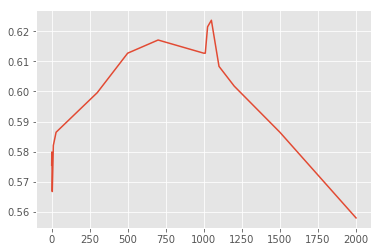

In [25]:
## GRAPH. about variation of K in KNN (by salvo)
import matplotlib.pyplot as mt
accuracy =[0.5754923413566739,0.5798687089715536,0.5776805251641138,0.5711159737417943,0.5667396061269147,0.5820568927789934,0.5864332603938731,0.5995623632385121,0.6061269146608315,0.612691466083151,0.6170678336980306,0.612691466083151,0.612691466083151,0.6214442013129103,0.6236323851203501,0.6083150984682714,0.6017505470459519,0.5864332603938731,0.5579868708971554]
k_value =[1,2,3,4,5,12,30,300,400,500,700,1000,1010,1025,1050,1100,1200,1500,2000]
mt.plot (k_value,accuracy)

##  Decision Tree 


In [66]:
# Trying to use Decision Tree with TF-IDF indexes   
# computed on standard BOW
from sklearn import tree
pl = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',tree.DecisionTreeClassifier(min_samples_split=5,criterion="entropy"))
])

# Adding tfidf paramterers to be tuned
params = {
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__use_idf': [True, False]
}

# Training and testing
gs = GridSearchCV(pl, params, scoring='accuracy', cv=5, iid=False, n_jobs=-1)
gs = train_test_gs(gs, Xtrain, Ytrain, Xtest, Ytest)


Confusion Matrix:
[[173  76]
 [115  93]]
Accuracy: 0.5820568927789934
Obtained by GridSearchCV with the following parameters:
 - tfidf__use_idf: True
 - vect__ngram_range: (1, 2)


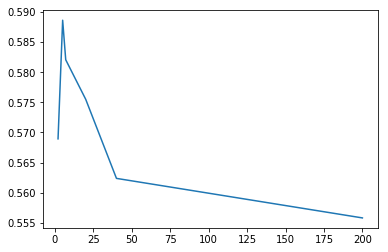

In [121]:
## GRAPH. about variation of min_samples_split in Decision Tree (by salvo)
import matplotlib.pyplot as mt
accuracy =[0.5689277899343544,0.5754923413566739,0.5886214442013129,0.5820568927789934,0.5754923413566739,0.562363238512035,0.5557986870897156]
min_samples_split_value =[2,3,5,7,20,40,200]
mt.plot (min_samples_split_value,accuracy)

## Decision Tree: Random Forest 


In [123]:
# Trying to use Random Forest with TF-IDF indexes   
# computed on standard BOW
from sklearn.ensemble import RandomForestClassifier
pl = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',RandomForestClassifier(n_estimators=1000,criterion='entropy',min_samples_split=1200))
])

# Adding tfidf paramterers to be tuned
params = {
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__use_idf': [True, False]
}

# Training and testing
gs = GridSearchCV(pl, params, scoring='accuracy', cv=5, iid=False, n_jobs=-1)
gs = train_test_gs(gs, Xtrain, Ytrain, Xtest, Ytest)


Confusion Matrix:
[[194  55]
 [122  86]]
Accuracy: 0.612691466083151
Obtained by GridSearchCV with the following parameters:
 - tfidf__use_idf: True
 - vect__ngram_range: (1, 2)


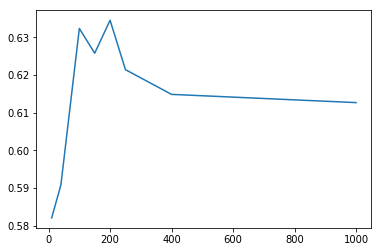

In [124]:
## GRAPH. about variation of n_estimators in Random Forest (by salvo)
import matplotlib.pyplot as mt
accuracy =[0.5820568927789934,0.5908096280087527,0.6323851203501094,0.6258205689277899,0.6345733041575492,0.6214442013129103,0.6148796498905909,0.612691466083151]
min_samples_split_value =[10,40,100,150,200,250,400,1000]
mt.plot (min_samples_split_value,accuracy)

## SVM 

In [30]:
# Trying to use Linear Support Vector Classification (SVM)  with TF-IDF indexes   
# computed on standard BOW
from sklearn.svm import LinearSVC

pl = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(class_weight='balanced'))
])

# Adding tfidf paramterers to be tuned
params = {
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__use_idf': [True, False],
    
    
}

# Training and testing
gs = GridSearchCV(pl, params, scoring='accuracy', cv=5, iid=False, n_jobs=-1)
gs = train_test_gs(gs, Xtrain, Ytrain, Xtest, Ytest)


Confusion Matrix:
[[152  97]
 [ 83 125]]
Accuracy: 0.6061269146608315
Obtained by GridSearchCV with the following parameters:
 - tfidf__use_idf: False
 - vect__ngram_range: (1, 3)
